# Starbucks Capstone Challenge

- <a id='TOC'>Table of Contents</a>
    - <a href='#Intro'>Introduction </a>
        - <a href='#Dataset'>Datasets definition </a>
        - <a href='#authornote'>Author Notes</a> 
    - <a href='#sec_0_0'>Section 0: Import Librarys and Data </a>
    - <a href='#sec_1_0'>Section 1: Clean and Organizae Data </a>
        - <a href='#sec_1_1'>Section 1.1: Match Transcript </a>
    - <a href='#sec_2_0'>Section 2: Explore Data </a>
        - <a href='#sec_2_1'>Section 2.1: Genreal Exploration </a>
        - <a href='#sec_2_2'>Section 2.2: Demographic Histographical Analysis </a>
        - <a href='#sec_2_3'>Section 2.3: Exploration of Offer Factors Variables </a>
        - <a href='#sec_2_4'>Section 2.3: Exploration of Response Variables </a>
    - <a href='#sec_3_0'>Section 3: Model Data </a>
    - <a href='#sec_4_0'>Section 4: Principle Component Analysis </a>



- Graphs
    -<a href='#fig2_4d'>
    -<a href='#fig2_4e'>Fig 2.4f</a>
    -<a href='#fig2_4g'>Fig 2.4g: Frequency of the Time of Offer Response (by gender)</a>

<a id='Intro'></a>
## Introduction  
<a href='#TOC'>Jump to top </a>

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

**Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type** This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

<a id='Dataset'></a>

### Data Sets
<a href='#TOC'>Jump to top </a>

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record


<a id='authornote'></a>
### Author Notes

Expanded notes on thought process are contained in <a href='Notes.ipynb'>Notes.ipynb Jupyter notebook</a> which is stored in the same directory

<a id='sec_0_0'></a>
## 0. Import Librarys and Data
<a href='#TOC'>Jump to top </a>

In [81]:
import pandas as pd
import numpy as np
import math
from tqdm import tqdm
tqdm.pandas()
import json
import graphviz
import importlib
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics.classification import confusion_matrix
from sklearn.metrics import fbeta_score,accuracy_score,precision_score
import sklearn.metrics as met
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.proportion import proportions_ztest

from joblib import dump, load
%matplotlib inline


In [2]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

<a id='sec_1_0'></a>
## 1. Clean and Organize Data

<a href='#TOC'>Jump to top </a>

In [3]:
## Are all the missing gender and income on matching rows?
(17000-14825)==profile[(profile.gender.isna())&(profile.income.isna())].shape[0]

True

In [4]:
def organize_raw_data(portfolio=portfolio,profile=profile,transcript=transcript):
    ''' This function organizes the raw data via setting datatype, setting indexes, and onehotencoding
    input: Startbuck challenge raw dataframes: portfolio,profile, and transcrips
    
    output: (7 dataframes, 3 revised originals and 4 which are filtered versions of transcript)
    portfolio_new: portfolio (one hot encoded channels, some column renames)
    profile_new: cleaned profile (member start date to datetime, one hot encoded gender)
    transcript_new: cleaned transcript 
        (value dict-> one hot encoded event type, 
        amount(spend), reward(completion), offer_id(offers,view/complte))
    t_offer: transcript_new filtered:offers only
    t_viewed: transcript_new filtered:viewed only
    t_trans: transcript_new filtered:transactions only
    t_compl: transcript_new filtered:complteted offers only
    
    '''
    
    
    ############### Portfolio
    portfolio.rename(columns={'id':'offer_id'},inplace=True) # match other table
    
    # one hot encode channels
    mlb = MultiLabelBinarizer() 
    portfolio = portfolio.join(pd.DataFrame(mlb.fit_transform(portfolio.pop('channels')),
                          columns=mlb.classes_,
                          index=portfolio.index))
    portfolio = portfolio.merge(pd.get_dummies(portfolio['offer_type'],prefix='offer',prefix_sep='_'),left_index=True,right_index=True)
    #portfolio.drop(columns='offer_type',inplace=True)
    # Since offer_id is unique, we can use that as an index
    portfolio.set_index('offer_id')
    
    ############### Profile
    #Split/Drop N/A  - approx 13% of profile data was missing gender and income, the rows missing gender also are missing income.
    #  Will look to see if there are any differences later on
    profile_na = profile[profile.gender.isna()]
    #profile = profile.dropna(axis = 0)  - Will be doing this later so the profile N/A lines will be processed
    
    #Convert to datetime
    profile.loc[:,'became_member_on']=pd.to_datetime(profile['became_member_on'],format='%Y%m%d')
    
    #one hot encode gender
    profile = profile.merge(pd.get_dummies(profile['gender'],prefix='gender',prefix_sep='_'),left_index=True,right_index=True)
    
    # Since id is unique, we can use that as an index
    profile.set_index('id',inplace=True)
    
    
    ################# Transcript
    
    # expand dict in 'value' to its own columns per dict key
    transcript = transcript.merge(transcript.value.apply(pd.Series),left_index=True,right_index=True)
    
    # cleaning up 'offer_id' and 'offer id', so as there is a single column
    transcript.loc[transcript['offer_id'].isna(),'offer_id'] = transcript[transcript['offer_id'].isna()]['offer id']
    
    #one hot encode event (transaction type)
    transcript = transcript.merge(pd.get_dummies(transcript['event'],prefix='event',prefix_sep='_'),left_index=True, right_index=True)
    transcript.drop(columns = ['offer id','value'],inplace=True)
    
    transcript = transcript[transcript['person'].isin(profile.index)].reset_index()
    
    #break apart into sub-df based on transaction tyle
    t_offer = transcript[transcript['event']=='offer received']
    t_viewed = transcript[transcript['event']=='offer viewed']
    t_trans = transcript[transcript['event']=='transaction']
    t_compl = transcript[transcript['event']=='offer completed']
    
    return portfolio,profile,profile_na,transcript,t_offer,t_viewed,t_trans,t_compl

In [5]:
portfolio_new,profile_new,profile_na,transcript_new,t_offer,t_viewed,t_trans,t_compl = organize_raw_data()

<a href='#pick_load'>Jump to the latest pickle load checkpoint</a>

In [ ]:
print('portfolio:', portfolio.shape)
print('portfolio_new',portfolio_new.shape)
print('profile',profile.shape)
print('profile_new', profile_new.shape)
print('transcript',transcript.shape)
print('transcript_new',transcript_new.shape)
print('t_offer',t_offer.shape)
print('t_viewed',t_viewed.shape)
print('t_compl',t_compl.shape)
print('t_trans',t_trans.shape)


<a id='sec_1_1'></a>
### 1.1 Matching Events
<a href='#TOC'>Jump to top </a>

The purpose of this section is to match pertinent events to thier respective offer.  So you have one row representing a series of events.
- All counted views are performed within the time window: time (of offer) + duration of offer
- All counted transactions are performed within the time window and after they view the offer.
- All rewards occur within time wintow

In [ ]:
###Lookup the duration of each offer and convert to hours to match offer time data.
###and create a time end

t_matched = pd.merge(t_offer,portfolio[['offer_id','duration']],on=['offer_id'],how='left')
t_matched['duration'] =t_matched['duration'].progress_apply(lambda x: x*24)
t_matched['time_end'] = t_matched['time'] + t_matched['duration']


###
### Merge view transcripts!
###

def id_viewed(row):
    ''' matches up offers and views by same person and offer within time limit.   
    Marks offer/person/time as viewed and notes the time of the view.
    
    input: df row per pd.apply()
    output: updated df row 
    '''
    for idx,trn in t_viewed[(t_viewed.person == row.person)&(t_viewed.offer_id == row.offer_id)].sort_values(by='time').iterrows():
        if (trn.time >= row.time) & (trn.time < row.time_end ):
            row['event_offer viewed'] = 1
            row['time_viewed'] = trn['time']
            return row
    return row

t_matched = t_matched.progress_apply(id_viewed,axis=1)

###
### merge transaction transcript!
###

t_matched['trans_time'] = np.nan
#t_matched['trans_index'] = np.nan  # Vestigal
t_matched['trans_spend'] = np.nan


def scrub_trans(row):
    '''
    Matches transactions to offer based on the following conditions
    - person matches
    - transaction was made after offer was made
    - transaction was viewed
    - transaction was made after the offer was viewed
    - transaction was made before offer expired.
    '''
    #print(row['person'])
    for idx,trn in t_trans[t_trans.person == row.person].sort_values(by='time').iterrows():
        if (trn.time >= row.time) & (row['event_offer viewed']==1) &(trn.time < row.time_end ) & (trn.time >= row.time_viewed):
            row['event_transaction'] = 1
            row['trans_time'] = trn['time']
            row['trans_spend'] = trn['amount']
            return row
    return row
 

t_matched = t_matched.progress_apply(scrub_trans,axis=1)



###
### Merge completed transactions
###

t_matched['reward'] = np.nan

def scrub_compl(row):
    '''   
    Runs through the t_offer dataframe and marks offer as complete under the following contionds
    

    marks the offer complete if
    - person and offer match
    - 
    
    input: df row per pd.apply() function
    '''
    for idx,trn in t_compl[(t_compl.person == row.person)&(t_compl.offer_id == row.offer_id)].sort_values(by='time').iterrows():
        if (trn.time >= row.time) & (trn.time < row.time_end ):
            row['event_offer completed'] = 1
            row['reward'] = trn.reward
            
            return row
    return row
 

t_matched = t_matched.progress_apply(scrub_compl,axis=1)

In [ ]:


###
### Save df to pickle
###

t_matched.to_pickle('combined_trans.pkl')

In [ ]:
events = pd.read_pickle('combined_trans.pkl')

**Combine profile and portfolio information to each line**

In [ ]:
# Merge pertinant fields from profile
prof_merge_col = ['age','income','gender','gender_F',
       'gender_M', 'gender_O', 'memb_leng']

events = events.merge(profile_new[prof_merge_col],how='left',left_on='person',right_on=profile_new.index)

# Merge pertinant fields from portfolio

port_merge_col = ['difficulty', 'offer_id', 'email', 'mobile',
       'social', 'web', 'offer_bogo', 'offer_discount',
       'offer_informational','reward']

events = events.merge(portfolio_new[port_merge_col],on='offer_id')
events.rename(columns={'reward_x':'reward_rcvd','reward_y':'reward_offd'},inplace=True)

#Other
events.drop(columns='amount',inplace=True)
events.rename(columns={'event_offer completed':'event_offer_completed','event_offer received':'event_offer_received','event_offer viewed':'event_offer_viewed'},inplace=True)

In [ ]:
events.info()

**N/A Strategy**

There are five columns with N/A in the data
    - time_viewed
    - trans_time
    - trans_spend
    - reward
    - income
    - gender
    
    1) time_viewed and trans_time are response variables (y) for those who completed those tasks.  I will remove these from the dataset for any predictive modeling
    2) Income and gender are omitted on appox 13% of records.  Important  to note that the income and gender are all missing from the same lines. Will remove these later when pertinant
    3) trans_spend and reward should be zero,because if there was no transaction there was no spend nor reward

In [ ]:
##mod
events.trans_spend.fillna(value=0,inplace=True)
events.reward_rcvd.fillna(value=0,inplace=True)

In [ ]:
events.to_pickle('events_merged.pkl')

<a id='pick_load'> Pickle Load</a>


In [6]:
events_merged = pd.read_pickle('events_merged.pkl')

In [7]:
#identify how long member 
##mod

profile_new['memb_leng'] = (profile_new.became_member_on.max()-profile_new.became_member_on).dt.days.astype(float)/(365.25/12)

In [8]:
from sklearn.preprocessing import MinMaxScaler

In [9]:
scaler = MinMaxScaler()

Preparing the Data per CharityML

Transform Skewed features
Normalizing Numerical Features
shuffle and split data

import 3 supervised learning models



In [10]:
def norm_and_std(df):
    from sklearn.preprocessing import MinMaxScaler
    from sklearn.preprocessing import StandardScaler
    '''This will create a copy of the df with standardized and normalzied columns'''
   
    ## non-boolean columns
    ''''', 'event', 'index', 'offer_id',
       'person', 'reward', 'time', 'time_end', 'time_viewed', 'trans_time',
       'trans_spend', 'age', 'income', 'gender', 'gender_F', 'gender_M',
       'gender_O', 'memb_leng', 'difficulty', 'email', 'mobile', 'social',
       'web', 'offer_bogo', 'offer_discount', 'offer_informational', 't_std',
       'time_viewed', 'trans_time'
    '''
    '''
    '''
    ## Normalize ##########################
    '''duration,reward,'time', 'time_end', 'time_viewed', 'trans_time',
       'trans_spend',difficulty
    '''
    
    ## Standardize
    ''''age', 'income','memb_leng'
    '''
    ## Drop
    '''event,index,offer_id,person,'gender' '''
    ## Bool
    '''
    'gender_F', 'gender_M',
       'gender_O,'email', 'mobile', 'social',
       'web', 'offer_bogo', 'offer_discount', 'offer_informational', 't_std'
       '''
    
    df2 = df.copy()
    
    ## Drop
    drop_na_cols = ['age','income','gender']
    df2.dropna(subset=drop_na_cols,inplace=True)
    
    drop_cols = ['event','index','offer_id','person','gender']
    df2.drop(drop_cols,inplace=True,axis=1)
    
    #Normalize time series data
    #I am normalizing this to the timescale of the individual offer.
    
    df2.loc[:,'time_viewed'] = (df2.time_viewed - df2.time) / (df2.time_end - df2.time )
    df2.loc[:,'trans_time'] = (df2.trans_time - df2.time) / (df2.time_end - df2.time )
    df2.loc[:,'time'] = (df2.time)/df2.time.max()
    
    #Normalizing since relative magnitude is important for these.
    mm_scaler = MinMaxScaler()
    df2[['difficulty','reward_rcvd','reward_offd','duration']] = mm_scaler.fit_transform(df2[['difficulty','reward_rcvd','reward_offd','duration']])
    
    ## Standardize
    s_scaler = StandardScaler()
    std_cols = ['age', 'income','memb_leng']
    df2[std_cols] = s_scaler.fit_transform(df2[std_cols])
    
  
    
    ## Standardize
    # Columns: 
    # New Colun
    return df2

In [11]:
events_merged_std = norm_and_std(events_merged)

In [12]:
events_merged_nona = events_merged.dropna(subset=['age','gender','income'])

<a id='pickleload'></a>

<a id='sec_2_0'></a>
## Section 2.0: Explore Data
<a href='#TOC'>Jump to top</a>

<a id='sec_2_1'></a>
### Section 2.1: General Exploration
<a href='#TOC'>Jump to top</a>

In [13]:
events_merged.columns

Index(['duration', 'event', 'event_offer_completed', 'event_offer_received',
       'event_offer_viewed', 'event_transaction', 'index', 'offer_id',
       'person', 'reward_rcvd', 'time', 'time_end', 'time_viewed',
       'trans_time', 'trans_spend', 'age', 'income', 'gender', 'gender_F',
       'gender_M', 'gender_O', 'memb_leng', 'difficulty', 'email', 'mobile',
       'social', 'web', 'offer_bogo', 'offer_discount', 'offer_informational',
       'reward_offd'],
      dtype='object')

In [14]:
print(events_merged[['event_offer_received','event_offer_viewed','event_transaction','event_offer_completed']].sum())

tot_offers = events_merged.event_offer_received.sum()
tot_off_viewed = events_merged.event_offer_viewed.sum()
tot_off_purchased = events_merged.event_transaction.sum()
tot_off_rewarded = events_merged.event_offer_completed.sum()



tot_sum_purch = events_merged.trans_spend.sum()
#tot_sum_reward = events_merged.reward.sum()


print('Percentage viewed : {0:.2f}%'.format(100* tot_off_viewed/tot_offers))
print('Percentage offers purchased : {0:.2f}%'.format(100*tot_off_purchased/tot_offers))
print('Percentage offers viewed puchased : {0:.2f}%'.format(100*tot_off_purchased/tot_off_viewed))
print('Percentage of offers that were rewarded  : {0:.2f}%'.format(100*tot_off_rewarded/tot_off_purchased))
print('Percentage of purchases that were rewarded  : {0:.2f}%'.format(100*tot_off_rewarded/tot_off_purchased))

event_offer_received     76277
event_offer_viewed       56651
event_transaction        43067
event_offer_completed    33195
dtype: int64
Percentage viewed : 74.27%
Percentage offers purchased : 56.46%
Percentage offers viewed puchased : 76.02%
Percentage of offers that were rewarded  : 77.08%
Percentage of purchases that were rewarded  : 77.08%


<a id='sec_2_2'></a>
### Section 2.2: Demographic Histographical Analysis
<a href='#TOC'>Jump to top</a>

In [15]:
# removing the N/A for demographic analysis

Text(0.5,1,'Fig 2.2a: Distribution of Income')

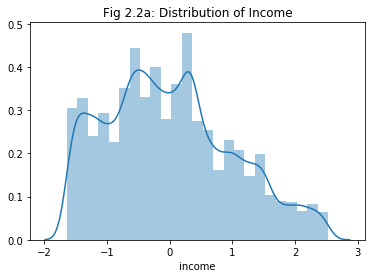

In [16]:
ax2_2a = sns.distplot(events_merged_std.income,bins=25)
ax2_2a.set_title('Fig 2.2a: Distribution of Income')

In [17]:
#it appears that there are some groupings in this distribution

Text(0.5,0.8,'Fig 2.2b_3: Income Distribution (Other)')

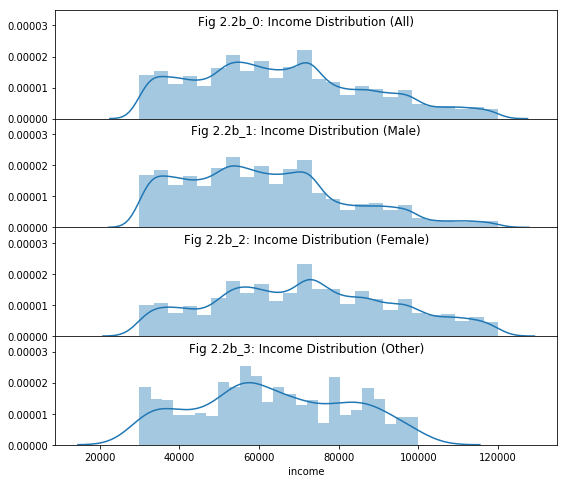

In [18]:
fig_2_2b, (ax22b_0, ax22b_1, ax22b_2, ax22b_3) = plt.subplots(nrows=4, sharex=True,sharey=True, figsize=(9,8))
plt.ylim([0,0.000035])
fig_2_2b.subplots_adjust(hspace = 0)
sns.distplot(events_merged_nona.income,bins=25,ax=ax22b_0)
sns.distplot(events_merged_nona[events_merged_nona.gender_M == 1].income,bins=25,ax=ax22b_1)
sns.distplot(events_merged_nona[events_merged_nona.gender_F == 1].income,bins=25,ax=ax22b_2)
sns.distplot(events_merged_nona[events_merged_nona.gender_O == 1].income,bins=25,ax=ax22b_3)
ax22b_0.set_title("Fig 2.2b_0: Income Distribution (All)",y=.8)
ax22b_1.set_title("Fig 2.2b_1: Income Distribution (Male)",y=.8)
ax22b_2.set_title("Fig 2.2b_2: Income Distribution (Female)",y=.8)
ax22b_3.set_title("Fig 2.2b_3: Income Distribution (Other)",y=.8)


There appears to be groupings within the income, that are not related to gender.  It apppears to be 3-5 subgroups.  There are possibly something implit here.

Text(0.5,0.8,'Fig 2.2c_3: Age Distribution (Other)')

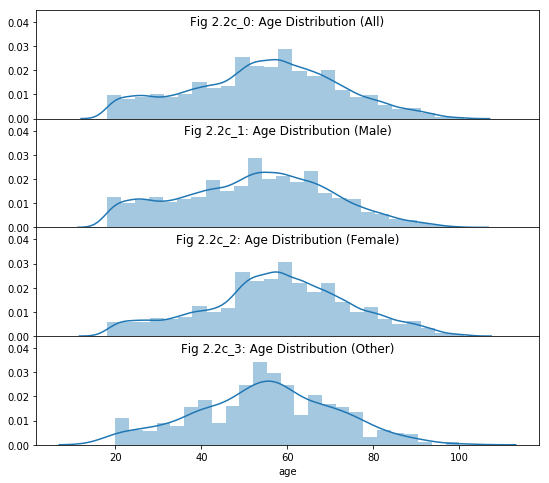

In [19]:
fig_2_2c, (ax22c_0, ax22c_1, ax22c_2, ax22c_3) = plt.subplots(nrows=4, sharey= True, sharex=True,figsize=(9,8))
plt.ylim([0,0.045])
fig_2_2c.subplots_adjust(hspace = 0)
#sns.distplot(events_merged.age.dropna(),bins=25,ax=ax2_0)
sns.distplot(events_merged_nona.age,bins=25,ax=ax22c_0)
sns.distplot(events_merged_nona[events_merged_nona.gender_M == 1].age,bins=25,ax=ax22c_1)
sns.distplot(events_merged_nona[events_merged_nona.gender_F == 1].age,bins=25,ax=ax22c_2)
sns.distplot(events_merged_nona[events_merged_nona.gender_O == 1].age,bins=25,ax=ax22c_3)
ax22c_0.set_title("Fig 2.2c_0: Age Distribution (All)",y=.8)
ax22c_1.set_title("Fig 2.2c_1: Age Distribution (Male)",y=.8)
ax22c_2.set_title("Fig 2.2c_2: Age Distribution (Female)",y=.8)
ax22c_3.set_title("Fig 2.2c_3: Age Distribution (Other)",y=.8)

There does appear to be two groupings here within the data

Text(0.5,0.8,'Fig 2.2 d_3: Membership Length Distribution (Other)')

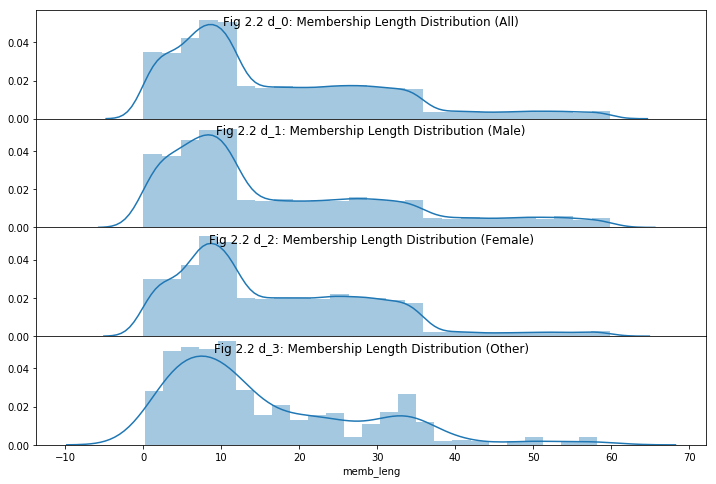

In [20]:
fig_2_2d, (ax22d_0,ax22d_1, ax22d_2, ax22d_3) = plt.subplots(nrows=4, sharex=True,sharey=True, figsize=(12,8))
fig_2_2d.subplots_adjust(hspace = 0)
sns.distplot(events_merged_nona.memb_leng,bins=25,ax=ax22d_0)
sns.distplot(events_merged_nona[events_merged_nona.gender_M == 1].memb_leng,bins=25,ax=ax22d_1)
sns.distplot(events_merged_nona[events_merged_nona.gender_F == 1].memb_leng,bins=25,ax=ax22d_2)
sns.distplot(events_merged_nona[events_merged_nona.gender_O == 1].memb_leng,bins=25,ax=ax22d_3)
ax22d_0.set_title("Fig 2.2 d_0: Membership Length Distribution (All)",y=.8)
ax22d_1.set_title("Fig 2.2 d_1: Membership Length Distribution (Male)",y=.8)
ax22d_2.set_title("Fig 2.2 d_2: Membership Length Distribution (Female)",y=.8)
ax22d_3.set_title("Fig 2.2 d_3: Membership Length Distribution (Other)",y=.8)

There appears to be 3 distinct groups of members based on membership length
* members joining between ~38-58months
* members joining between ~12-38 months
* members joining in last 12 months 



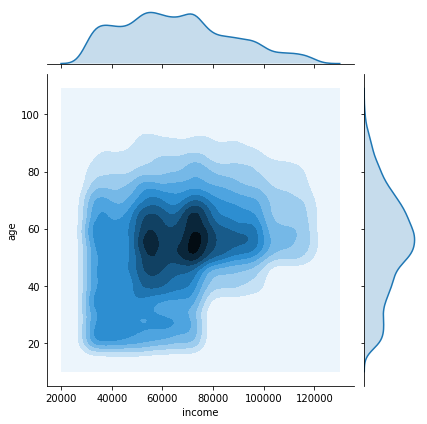

In [21]:
fig_2_2e = sns.jointplot(x='income',y='age',data=profile_new.dropna(subset=['income','age']),kind="kde")

Interesting here, the income distributions of younger folks is is limited to the lower end of the range and expandands as age increases.  Also age skews lower.

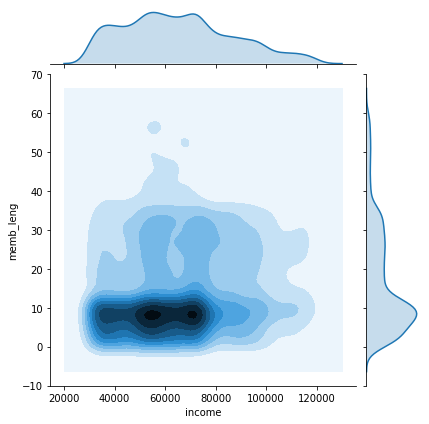

In [22]:
fig_2_2f = sns.jointplot(x=profile_new.dropna(subset=['income','age']).income,y=profile_new.dropna(subset=['income','age']).memb_leng,kind="kde")

It appears that the early and mid adopters tend to be distributed roughly the same as the general population.  

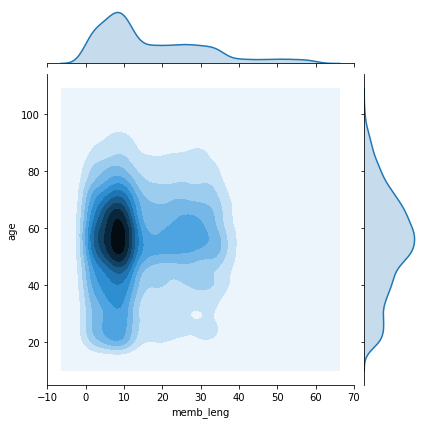

In [23]:
fig_2_2g = sns.jointplot(x='memb_leng',y='age',data=profile_new.dropna(subset=['income','age']),kind="kde")

<a id='sec_2_3'></a>
## Section 2.3: Explore Offer Factors
<a href='#TOC'>Jump to top</a>

What do we want to know about the study factors?
- Person
    - [X] What is the distribution of offers
- Offer_Id (there are 10 offer ids)
    - [X] How many offers were made of each ID?
    - [X] How many offers were made to each person, on average?
- Difficulty
    - [X] What was the representative range of difficulty?  avg offer vs avg person?
- Distribution Method
    - [X]  
- Offer Type
    - [ ] 
- Reward
    

In [24]:
events_merged.pivot_table(values = 'event_offer_received', index='person',columns='offer_id',aggfunc='count',fill_value=0).sum(axis=0)

offer_id
0b1e1539f2cc45b7b9fa7c272da2e1d7    7668
2298d6c36e964ae4a3e7e9706d1fb8c2    7646
2906b810c7d4411798c6938adc9daaa5    7632
3f207df678b143eea3cee63160fa8bed    7617
4d5c57ea9a6940dd891ad53e9dbe8da0    7593
5a8bc65990b245e5a138643cd4eb9837    7618
9b98b8c7a33c4b65b9aebfe6a799e6d9    7677
ae264e3637204a6fb9bb56bc8210ddfd    7658
f19421c1d4aa40978ebb69ca19b0e20d    7571
fafdcd668e3743c1bb461111dcafc2a4    7597
dtype: int64

In [25]:
events_merged.pivot_table(values = 'event_offer_received', index='person',columns='offer_id',aggfunc='count',fill_value=0).sum(axis=1).mean()

4.488466517594445

Text(0.5,1,'Fig 2.3a: Distribution of the proportion of offers an individual recieved')

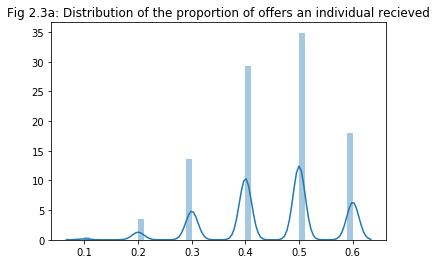

In [26]:
fig_2_3a = sns.distplot(events_merged.pivot_table(values = 'event_offer_received', index='person',columns='offer_id',aggfunc='count',fill_value=0).mean(axis=1))
fig_2_3a.set_title("Fig 2.3a: Distribution of the proportion of offers an individual recieved")

In [27]:
events_merged.pivot_table(values = 'event_offer_received', index='person',columns='offer_id',aggfunc='count',fill_value=0).mean(axis=1).mode()

0    0.5
dtype: float64

Average Offer Difficulty:  7.7


Text(0.5,1,'Fig 2.3b: Distribution of average (by person) offer difficulty')

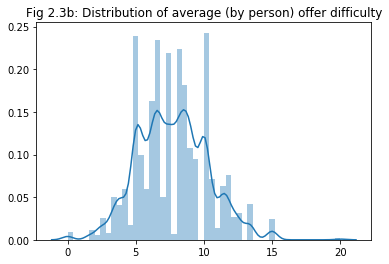

In [28]:
print("Average Offer Difficulty: ",portfolio_new.difficulty.mean())

fig_2_3b = sns.distplot(events_merged.pivot_table(values = 'difficulty', index='person',columns='offer_id',aggfunc='mean').mean(axis=1))
fig_2_3b.set_title("Fig 2.3b: Distribution of average (by person) offer difficulty")

In [29]:
portfolio_new

,difficulty,duration,offer_id,offer_type,reward,email,mobile,social,web,offer_bogo,offer_discount,offer_informational
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0,1,0,0
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1,1,0,0
2,0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,0,1,0,0,1
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,0,1,1,0,0
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,0,0,1,0,1,0
5,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3,1,1,1,1,0,1,0
6,10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2,1,1,1,1,0,1,0
7,0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0,1,1,1,0,0,0,1
8,5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,1,1,1,1,1,0,0
9,10,7,2906b810c7d4411798c6938adc9daaa5,discount,2,1,1,0,1,0,1,0


<a id='sec_2_4'></a>
## Section 2.4: Explore Response Variable
<a href='#TOC'>Jump to top</a>

In [30]:
print(events_merged[['event_offer_received','event_offer_viewed','event_transaction','event_offer_completed']].sum())

tot_offers = events_merged.event_offer_received.sum()
tot_off_viewed = events_merged.event_offer_viewed.sum()
tot_off_purchased = events_merged.event_transaction.sum()
tot_off_rewarded = events_merged.event_offer_completed.sum()



tot_sum_purch = events_merged.trans_spend.sum()
#tot_sum_reward = events_merged.reward.sum()


print('Percentage viewed : {0:.2f}%'.format(100* tot_off_viewed/tot_offers))
print('Percentage offers purchased : {0:.2f}%'.format(100*tot_off_purchased/tot_offers))
print('Percentage offers viewed puchased : {0:.2f}%'.format(100*tot_off_purchased/tot_off_viewed))
print('Percentage of offers that were rewarded  : {0:.2f}%'.format(100*tot_off_rewarded/tot_off_purchased))
print('Percentage of purchases that were rewarded  : {0:.2f}%'.format(100*tot_off_rewarded/tot_off_purchased))

event_offer_received     76277
event_offer_viewed       56651
event_transaction        43067
event_offer_completed    33195
dtype: int64
Percentage viewed : 74.27%
Percentage offers purchased : 56.46%
Percentage offers viewed puchased : 76.02%
Percentage of offers that were rewarded  : 77.08%
Percentage of purchases that were rewarded  : 77.08%


First lets explore the main question in the simplist way possible?  Is there an overarching coorelation in purchasing to any demographic?

Text(0.5,1,'Fig 2.4a: Coorelation Heatmap')

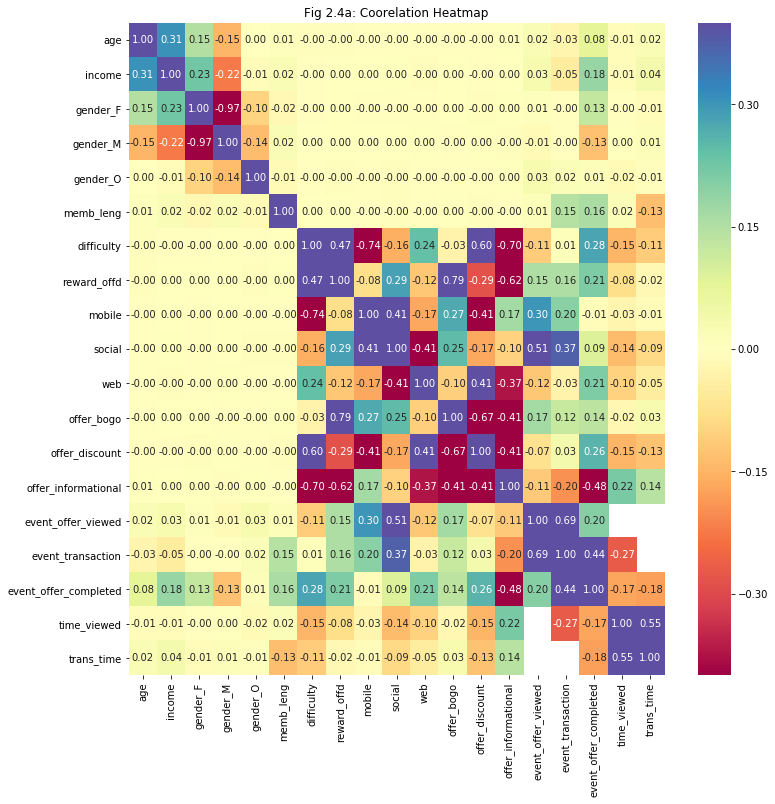

In [31]:
fig_2_4a, ax_2_4a = plt.subplots(figsize=(12,12))
sns.heatmap(events_merged_std[['age', 'income', 'gender_F', 'gender_M', 'gender_O','memb_leng', 'difficulty','reward_offd', 'mobile', 'social', 'web',
       'offer_bogo', 'offer_discount', 'offer_informational',
       'event_offer_viewed', 'event_transaction', 'event_offer_completed','time_viewed',
       'trans_time']].corr(),annot=True,ax=ax_2_4a,cmap='Spectral',vmin=-0.4, vmax=0.4,fmt='.2f')
ax_2_4a.set_title('Fig 2.4a: Coorelation Heatmap')

There is a lot of information in this cooreation matrix.  I am focusing on which factors coorelate the most with event offer viewed, trans, and completion.

    - Viewed
        - Top Positive Coorelation
            - Offer on social media (0.5)
            - Offered on mobile platform (0.3)
        - Top Negative Coorelations
            - informational offer
            - difficulty
    - Transaction
        - Top Positive Coorelation
            - Offer on social media (0.37)
            - Offered on mobile platform (0.2)
        - Top Negative Coorelation
            - Informational Offer (-0.20)
    - Completion
        - Top Positive Coorelations
            - Difficulty (0.28)
            - Offer discount (0.26)
            - income (0.18)
        - Top Negative Coorelations
            - Offer_informational (-0.48) - This makes sense since informational offers didnt include rewards
            - gender_M (-0.13)

    

Text(0.5,0.98,'Fig 2.4: Actions Completed by age ')

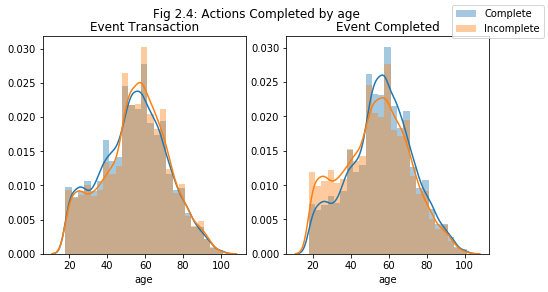

In [32]:

fig_2_4b, ax_2_4b = plt.subplots(nrows=1, ncols=2,figsize=(8,4))
sns.distplot(events_merged_nona[events_merged_nona.event_transaction==1].age,bins=25,ax=ax_2_4b[0])
sns.distplot(events_merged_nona[events_merged_nona.event_transaction==0].age,bins=25,ax=ax_2_4b[0])
sns.distplot(events_merged_nona[events_merged_nona.event_offer_completed==1].age,bins=25,ax=ax_2_4b[1])
sns.distplot(events_merged_nona[events_merged_nona.event_offer_completed==0].age,bins=25,ax=ax_2_4b[1])
ax_2_4b[0].set_title('Event Transaction')
ax_2_4b[1].set_title('Event Completed')
fig_2_4b.legend(labels=['Complete','Incomplete'])
fig_2_4b.suptitle('Fig 2.4: Actions Completed by age ')

The curves are almost identical, there does not seem to be an effect on age in making a transaciton

Text(0.5,0.98,'Fig 2.4c: Actions Completed by Income')

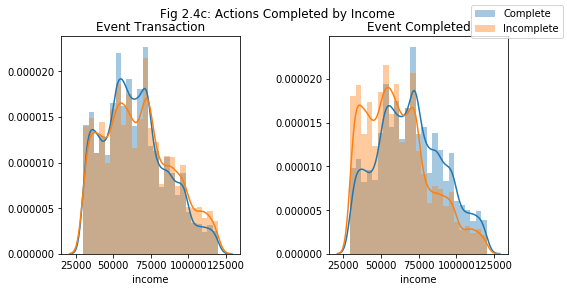

In [33]:
fig_2_4c , ax_2_24c = plt.subplots(nrows=1, ncols=2,figsize=(8,4))
fig_2_4c.subplots_adjust(hspace = .2,wspace = .5)
sns.distplot(events_merged[events_merged.event_transaction==1].income.dropna(),bins=25,ax=ax_2_24c[0])
sns.distplot(events_merged[events_merged.event_transaction==0].income.dropna(),bins=25,ax=ax_2_24c[0])
sns.distplot(events_merged[events_merged.event_offer_completed==1].income.dropna(),bins=25,ax=ax_2_24c[1])
sns.distplot(events_merged[events_merged.event_offer_completed==0].income.dropna(),bins=25,ax=ax_2_24c[1])
ax_2_24c[0].set_title('Event Transaction')
ax_2_24c[1].set_title('Event Completed')
fig_2_4c.legend(labels=['Complete','Incomplete'])
fig_2_4c.suptitle('Fig 2.4c: Actions Completed by Income')

**Note** The two populatons are virtually overlapped in the event transaction.  But in the event completed (read: complete = received reward incomplete=info only) there is a little offset in the income of those who completed, the difference is likley not significant, it might suggest that people with higher incomes are more likley to responsd to promotions with rewards in compared to this with lower incomes.   

* I think I need some stats help on this one, I belive I would use a  Kolmogorov-Smirnov test, but I am not sure.

Text(0.5,0.98,'Fig 2.4d: Actions Completed by Gender')

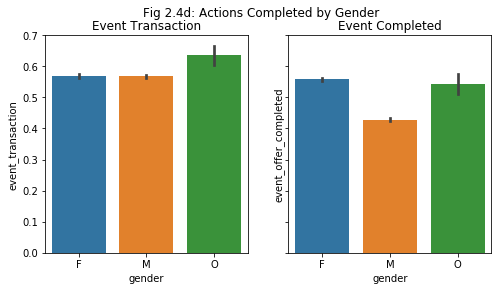

In [34]:
fig_2_4d, ax_2_4d = plt.subplots(nrows=1,ncols=2,figsize=(8,4),sharey=True)
sns.barplot(x=events_merged.gender,y=events_merged.event_transaction,ax=ax_2_4d[0])
sns.barplot(x=events_merged.gender,y=events_merged.event_offer_completed,ax=ax_2_4d[1])
ax_2_4d[0].set_title('Event Transaction')
ax_2_4d[1].set_title('Event Completed')
fig_2_4d.suptitle('Fig 2.4d: Actions Completed by Gender')

Men and Women appear to transact after viewing and offer at the same rate, but men disproportionally do not respond to the reward offers.  What is the baseline purchase frequency?

Text(0.5,1,'Fig 2.4e: Frequency of the number of offers individuals recieve ')

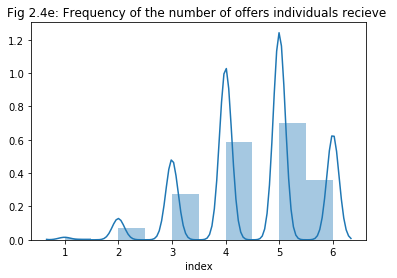

In [35]:
fig2_4e = sns.distplot(events_merged.groupby(by='person').count()['index'],bins=10)
fig2_4e.set_title("Fig 2.4e: Frequency of the number of offers individuals recieve ")

What do we want to know about the study factors?
- Person
   - What is the distribution of offers
- Offer_Id (there are 10 offer ids)
  - How many offers were made of each ID?
  - How many offers were made to each person, on average?
- Difficulty
  - What was the representative range of difficulty?
- Distribution Method
  - 
- Offer Type
- Reward

In [36]:
events_merged.groupby(by='offer_id').count()['index']

offer_id
0b1e1539f2cc45b7b9fa7c272da2e1d7    7668
2298d6c36e964ae4a3e7e9706d1fb8c2    7646
2906b810c7d4411798c6938adc9daaa5    7632
3f207df678b143eea3cee63160fa8bed    7617
4d5c57ea9a6940dd891ad53e9dbe8da0    7593
5a8bc65990b245e5a138643cd4eb9837    7618
9b98b8c7a33c4b65b9aebfe6a799e6d9    7677
ae264e3637204a6fb9bb56bc8210ddfd    7658
f19421c1d4aa40978ebb69ca19b0e20d    7571
fafdcd668e3743c1bb461111dcafc2a4    7597
Name: index, dtype: int64

In [37]:
events_merged.pivot_table(values='index',aggfunc='count',index='offer_id',columns=['person']).mean(axis=1)

offer_id
0b1e1539f2cc45b7b9fa7c272da2e1d7    1.203012
2298d6c36e964ae4a3e7e9706d1fb8c2    1.208854
2906b810c7d4411798c6938adc9daaa5    1.214320
3f207df678b143eea3cee63160fa8bed    1.203127
4d5c57ea9a6940dd891ad53e9dbe8da0    1.199526
5a8bc65990b245e5a138643cd4eb9837    1.205380
9b98b8c7a33c4b65b9aebfe6a799e6d9    1.208025
ae264e3637204a6fb9bb56bc8210ddfd    1.201443
f19421c1d4aa40978ebb69ca19b0e20d    1.209039
fafdcd668e3743c1bb461111dcafc2a4    1.199779
dtype: float64

Text(0.5,0.98,'Fig 2.4: Frequency of the Time of Offer Response')

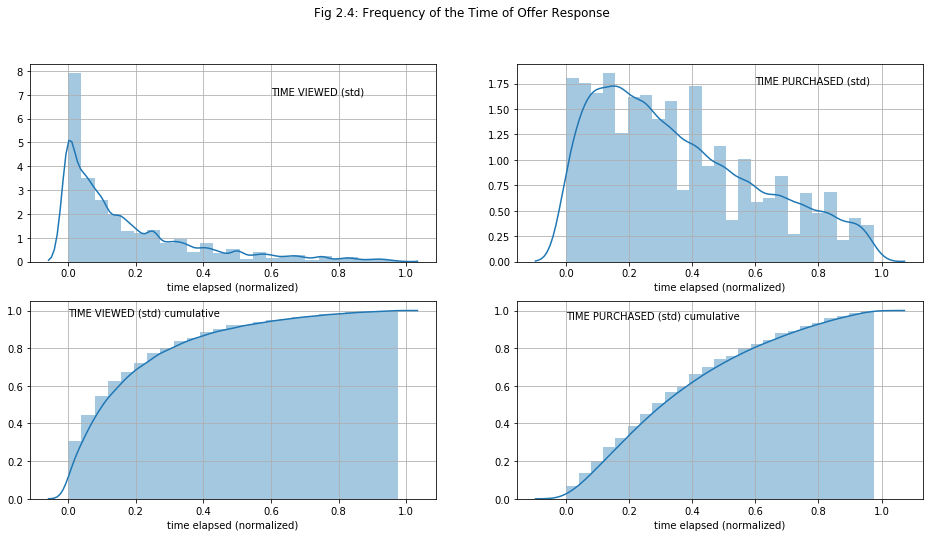

In [38]:
fig2_4f, ax_2_4f = plt.subplots(nrows=2, ncols=2, sharex=False, sharey=False, figsize=(16,8))
fig2_4f.subplots_adjust(hspace = .2,wspace = .2)

sns.distplot(events_merged_std.time_viewed.dropna(),bins=25,ax=ax_2_4f[0,0],norm_hist=True)
sns.distplot(events_merged_std.time_viewed.dropna(),hist_kws=dict(density=True,cumulative=True), kde_kws=dict(cumulative=True),bins=25,ax=ax_2_4f[1,0])
sns.distplot(events_merged_std.trans_time.dropna(),bins=25,ax=ax_2_4f[0,1],norm_hist=True)
sns.distplot(events_merged_std.trans_time.dropna(), hist_kws=dict(density=True,cumulative=True), kde_kws=dict(cumulative=True),ax=ax_2_4f[1,1],bins=25)

for i,j in np.ndenumerate(ax_2_4f):
    ax_2_4f[i].grid(b=True)
    ax_2_4f[i].set(xlabel='time elapsed (normalized)')

ax_2_4f[0,0].annotate(s='TIME VIEWED (std)',xy = (0.6,7.0) )
ax_2_4f[1,0].annotate(s='TIME VIEWED (std) cumulative',xy = (0,.975) )
ax_2_4f[0,1].annotate(s='TIME PURCHASED (std)',xy = (0.6, 1.75) )
ax_2_4f[1,1].annotate(s='TIME PURCHASED (std) cumulative',xy = (0,.955) )
fig2_4f.suptitle("Fig 2.4: Frequency of the Time of Offer Response")


Analysis:  The average view time is seemly early.  With 80% of people who will view it will view it witin the forst 30% of the time period.
The purchasing cumlative curve is flatter than the viewed cumulative curve and doesnt reach its inflection pount until about 70% of total respondeants reposnded at the 50% time point.

Text(0.5,0.98,'Fig 2.4g: Frequency of the Time of Offer Response (by gender)')

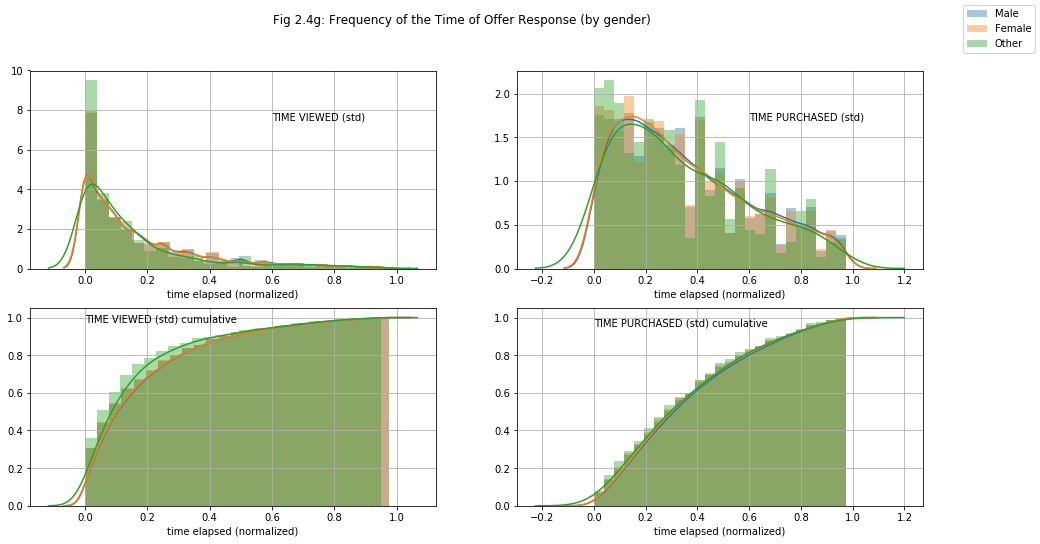

In [39]:
fig2_4g, ax_2_4g = plt.subplots(nrows=2, ncols=2, sharex=False, sharey=False, figsize=(16,8))
fig2_4g.subplots_adjust(hspace = .2,wspace = .2)

sns.distplot(events_merged_std[events_merged_std.gender_M==1].time_viewed.dropna(),bins=25,ax=ax_2_4g[0,0],norm_hist=True)
sns.distplot(events_merged_std[events_merged_std.gender_M==1].time_viewed.dropna(),hist_kws=dict(density=True,cumulative=True), kde_kws=dict(cumulative=True),bins=25,ax=ax_2_4g[1,0])
sns.distplot(events_merged_std[events_merged_std.gender_M==1].trans_time.dropna(),bins=25,ax=ax_2_4g[0,1],norm_hist=True)
sns.distplot(events_merged_std[events_merged_std.gender_M==1].trans_time.dropna(), hist_kws=dict(density=True,cumulative=True), kde_kws=dict(cumulative=True),ax=ax_2_4g[1,1],bins=25)
sns.distplot(events_merged_std[events_merged_std.gender_F==1].time_viewed.dropna(),bins=25,ax=ax_2_4g[0,0],norm_hist=True)
sns.distplot(events_merged_std[events_merged_std.gender_F==1].time_viewed.dropna(),hist_kws=dict(density=True,cumulative=True), kde_kws=dict(cumulative=True),bins=25,ax=ax_2_4g[1,0])
sns.distplot(events_merged_std[events_merged_std.gender_F==1].trans_time.dropna(),bins=25,ax=ax_2_4g[0,1],norm_hist=True)
sns.distplot(events_merged_std[events_merged_std.gender_F==1].trans_time.dropna(), hist_kws=dict(density=True,cumulative=True), kde_kws=dict(cumulative=True),ax=ax_2_4g[1,1],bins=25)
sns.distplot(events_merged_std[events_merged_std.gender_O==1].time_viewed.dropna(),bins=25,ax=ax_2_4g[0,0],norm_hist=True)
sns.distplot(events_merged_std[events_merged_std.gender_O==1].time_viewed.dropna(),hist_kws=dict(density=True,cumulative=True), kde_kws=dict(cumulative=True),bins=25,ax=ax_2_4g[1,0])
sns.distplot(events_merged_std[events_merged_std.gender_O==1].trans_time.dropna(),bins=25,ax=ax_2_4g[0,1],norm_hist=True)
sns.distplot(events_merged_std[events_merged_std.gender_O==1].trans_time.dropna(), hist_kws=dict(density=True,cumulative=True), kde_kws=dict(cumulative=True),ax=ax_2_4g[1,1],bins=25)

for i,j in np.ndenumerate(ax_2_4g):
    ax_2_4g[i].grid(b=True)
    ax_2_4g[i].set(xlabel='time elapsed (normalized)')

ax_2_4g[0,0].annotate(s='TIME VIEWED (std)',xy = (0.6,7.5) )
ax_2_4g[1,0].annotate(s='TIME VIEWED (std) cumulative',xy = (0,.975) )
ax_2_4g[0,1].annotate(s='TIME PURCHASED (std)',xy = (0.6, 1.7) )
ax_2_4g[1,1].annotate(s='TIME PURCHASED (std) cumulative',xy = (0,.955) )
fig2_4g.legend(labels=['Male','Female','Other'])
fig2_4g.suptitle("Fig 2.4g: Frequency of the Time of Offer Response (by gender)")


<a id='fig2_4g'> Figure 2.4g </a>
**Note** Virtually all three groups overalapped, no apparent difference between genders

In [40]:
events_merged_std.trans_time.mean()

0.35559526958515736

In [41]:
def impute_view_time(row):
    if np.isnan(row.time_viewed)==True:
        row.time_viewed = row.time_end
    return row

In [42]:
test = events_merged_std.apply(impute_view_time,axis=1)

In [43]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66501 entries, 0 to 76276
Data columns (total 26 columns):
duration                 66501 non-null float64
event_offer_completed    66501 non-null float64
event_offer_received     66501 non-null float64
event_offer_viewed       66501 non-null float64
event_transaction        66501 non-null float64
reward_rcvd              66501 non-null float64
time                     66501 non-null float64
time_end                 66501 non-null float64
time_viewed              66501 non-null float64
trans_time               37805 non-null float64
trans_spend              66501 non-null float64
age                      66501 non-null float64
income                   66501 non-null float64
gender_F                 66501 non-null float64
gender_M                 66501 non-null float64
gender_O                 66501 non-null float64
memb_leng                66501 non-null float64
difficulty               66501 non-null float64
email                    66

In [44]:
4

4

## Section 3.0:  Modeling
<a id='sec_3_0'></a>
<a href='#TOC'>Jump to top </a>

Ultimatly we would like to know, who is going to take the bait of 

In [45]:
def results_bool(y,y_hat,beta = 1.0, print_results=True,ret_results=True):
    ''' This function compares the results of a predicted to an actual 1d array
    
    This function will provide Accuracy, Precision, Recall and F_beta score 
    of a 1d bo0lean prediction array vs actual.
    
    Can print results and/or return a list [Accuracy, Precision, Recall, Fscore, beta]
    
    Input:
    y: (int) actual results
    y_hat: (int) predicted results
    beta: (float) beta of F-score values between 0 to 2 (default 1)
    print_results (default True)
    return_results (default True)
    
    Return (optional): (list) [Accuracy, Precision, Recall, Fscore, beta]
    '''
    # check if input arrays are binary 
    if ((y==1) | (y==0)).all()==False:
        raise Exception("Error: y is not binary")
    if ((y_hat==1) | (y_hat==0)).all()==False:
        raise Exception("Error: y_hat is not binary")
    
    # check beta
    if beta > 2 or beta < 0:
        print('beta {} exceeded 0 to 2 limit, setting beta = 1'.format(beta))
        beta = 1.0
        
    
    accuracy = np.sum(y==y_hat)/len(y)
    tp = len(np.intersect1d(np.where(y_hat==1),np.where(y==1)))
    precision = tp/((y_hat==1).sum())
    recall = tp/(y.sum())
    f_score = (1+beta**2)*(precision * recall )/(beta**2 * (precision + recall))
    
    if print_results==True:
        print('Results:\n--------------------------------------')
        print('{0:<12s} {1:0.2%}'.format('Accuracy: ',accuracy))
        print('{0:<12s} {1:0.2%}'.format('Precision: ',precision))
        print('{0:<12s} {1:0.2%}'.format('Recall: ',recall))
        print('{0:<12s} {1:0.4f}'.format('F_'+str(beta)+': ',f_score))
    
    if ret_results == True:
        return [accuracy, precision, recall, f_score, beta]
    else:
        return

    

In [46]:
events_merged_std.columns

Index(['duration', 'event_offer_completed', 'event_offer_received',
       'event_offer_viewed', 'event_transaction', 'reward_rcvd', 'time',
       'time_end', 'time_viewed', 'trans_time', 'trans_spend', 'age', 'income',
       'gender_F', 'gender_M', 'gender_O', 'memb_leng', 'difficulty', 'email',
       'mobile', 'social', 'web', 'offer_bogo', 'offer_discount',
       'offer_informational', 'reward_offd'],
      dtype='object')

In [47]:
X_col = ['duration','time','age', 'income',
       'gender_F', 'gender_M', 'gender_O', 'memb_leng', 'difficulty', 'email',
       'mobile', 'social', 'web', 'offer_bogo', 'offer_discount',
       'offer_informational', 'reward_offd']

KM_col = ['age', 'income',
       'gender_F', 'gender_M', 'gender_O', 'memb_leng']

X_sup = ['time_viewed']

X_sup2 =['reward_rcvd', 'trans_time', 'trans_spend']

Y_col = ['event_offer_completed', 'event_offer_received',
       'event_offer_viewed', 'event_transaction']



PL_col = ['time_end']


In [48]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [49]:
data = events_merged_std[KM_col]

In [50]:
centers = []
scores = []
s_score = []

for ii in range(2,35):
    kmeans = KMeans(ii)
    model = kmeans.fit(events_merged_std[KM_col])
    labels = model.predict(events_merged_std[KM_col])
    centers.append(ii)
    scores.append(abs(model.score(events_merged_std[KM_col])))

KeyboardInterrupt: 

In [51]:
def get_kmeans_score(data, center):
    '''
    returns the kmeans score regarding SSE for points to centers
    INPUT:
        data - the dataset you want to fit kmeans to
        center - the number of centers you want (the k value)
    OUTPUT:
        score - the SSE score for the kmeans model fit to the data
    '''
    #instantiate kmeans
    kmeans = KMeans(n_clusters=center)

    # Then fit the model to your data using the fit method
    model = kmeans.fit(data)

    # Obtain a score related to the model fit
    score = np.abs(model.score(data))

    return score

In [52]:
def fit_mods():
    scores = []
    centers = list(range(1,35))

    for center in centers:
        scores.append(get_kmeans_score(data, center))

    return centers, scores

In [ ]:
centers, scores = fit_mods()

#Your plot should look similar to the below
plt.plot(centers, scores, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('SSE');
plt.title('SSE vs. K');

In [ ]:
k_8 = KMeans(8)

In [ ]:
model_8 = k_8.fit(events_merged_std[KM_col])
labels_8 = model_8.transform(events_merged_std[KM_col])

In [ ]:
pred_8 = model_8.predict(events_merged_std[KM_col])

In [ ]:
pred_8.shape

In [ ]:
events_kpred = events_merged_std.reset_index()

In [ ]:
events_kpred.shape

In [ ]:
events_kpred = events_kpred.merge(pd.DataFrame(pred_8,columns=['pred']),left_index=True,right_index=True)

In [ ]:
preds = pd.get_dummies(events_kpred['pred'])

In [ ]:
events_kpred = events_kpred.merge(preds,left_index=True,right_index=True)

In [ ]:
events_kpred.head()

In [ ]:
events_kpred.columns

In [ ]:
fig_2_5a, ax_2_5a = plt.subplots(figsize=(12,12))
sns.heatmap(events_kpred[['duration','event_offer_completed','event_offer_received','event_offer_viewed','event_transaction','reward_rcvd','time',
                    'time_end','time_viewed','difficulty','email','mobile','social','web','offer_bogo','offer_discount','offer_informational',
                 'reward_offd',0,1,2,3,4,5,6,7]].corr(),annot=True,ax=ax_2_5a,cmap='Spectral',fmt='.2f')
ax_2_5a.set_title('Fig 2.5a: Coorelation Heatmap')

In [ ]:
events_merged_std.shape

In [ ]:
model_8.predict

In [ ]:
X_train, X_test, Y_train, Y_test,X_train_sup, X_test_sup = train_test_split(events_merged_std[X_col],events_merged_std[Y_col],events_merged_std[X_sup],train_size=0.7,random_state=72)
Y_train_view = Y_train['event_offer_viewed']
Y_test_view = Y_test['event_offer_viewed']

In [ ]:
clf_0 = GaussianNB()
clf_a = RandomForestClassifier()
clf_b = LogisticRegression()
clf_c = LinearSVC()

In [ ]:
X_train.columns

In [ ]:
clf_0.fit(X_train,Y_train['event_offer_viewed'])
clf_a.fit(X_train,Y_train['event_offer_viewed'])
clf_b.fit(X_train,Y_train['event_offer_viewed'])
clf_c.fit(X_train,Y_train['event_offer_viewed'])

In [ ]:
y1_pred_0 = clf_0.predict(X_test)
y1_pred_a = clf_a.predict(X_test)
y1_pred_b = clf_b.predict(X_test)
y1_pred_c = clf_c.predict(X_test)

In [ ]:

import visuals_new as vs  # Not written by author: Provied as part of CharityML project

In [ ]:
def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    from time import time
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    beta = 0.5   
    results = {}
    p_col = 'event_offer_viewed' #  column of y_data we are trying to learn
    
    # TODO: Fit the learner to the training data using slicing with 'sample_size' using .fit(training_features[:], training_labels[:])
    start = time() # Get start time
    learner.fit(X_train[:sample_size],y_train[p_col][:sample_size])  #since I left y_train with two columns (one for each) I required p_col to select column as well
    end = time() # Get end time
    
    # TODO: Calculate the training time - DONE
    results['train_time'] = end - start
        
    # TODO: Get the predictions on the test set(X_test),
    #       then get predictions on the first 300 training samples(X_train) using .predict()
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time() # Get end time
    
    # TODO: Calculate the total prediction time
    results['pred_time'] = end - start
            
    # TODO: Compute accuracy on the first 300 training samples which is y_train[:300]
    # note: TP + TN (i.e. sum of boolean of matching results) / # total sample
    #  np.sum(pred==acutal)/len(actual)
    results['acc_train'] = np.sum(predictions_train==y_train[p_col][:300])/len(y_train[p_col][:300])
        
    # TODO: Compute accuracy on test set using accuracy_score()
    results['acc_test'] =  np.sum(y_test[p_col] == predictions_test)/len(y_test[p_col])
    
    # TODO: Compute F-score on the the first 300 training samples using fbeta_score()
    results['f_train'] = fbeta_score(y_train[p_col][:300],predictions_train,beta)
        
    # TODO: Compute F-score on the test set which is y_test
    results['f_test'] = fbeta_score(y_test[p_col],predictions_test,beta)
       
    # Success
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    # Return the results
    return results

In [ ]:
samples_100 = len(Y_train_view)
samples_10 = int(len(Y_train_view)/10)
samples_1 = int(len(Y_train_view)/100)

# Collect results on the learners
results = {}
for clf in [clf_0,clf_b, clf_c, clf_a]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, Y_train, X_test, Y_test)

        

In [ ]:
importlib.reload(vs) 
vs.evaluate(results)

This shows that both RandomForrest works as well as slighty beter than some of the models.  I will use this.  Furthermore, it shows that a it can train well on a small sample size.
I will use this property to split my data up into 3 sets (train1, test1/train2, and test2)

In [ ]:
events_merged_std_shuffled = shuffle(events_merged_std,random_state=72)

In [ ]:
events_merged_std_shuffled.shape[0]/3

In [ ]:
e1 = events_merged_std_shuffled.iloc[:int(events_merged_std_shuffled.shape[0]/3),:]

In [ ]:
e2 = events_merged_std_shuffled.iloc[int(events_merged_std_shuffled.shape[0]/3)+1:int(events_merged_std_shuffled.shape[0]*2/3),:]

In [ ]:
e3 = events_merged_std_shuffled.iloc[int(events_merged_std_shuffled.shape[0]*2/3)+1:,:]

### Section 3.1: Predicting Views
<a id='sec_3_1'></a>
<a href='#TOC'>Jump to top</a>

In [68]:
e1_X = e1[X_col]
e2_X = e2[X_col]
e3_X = e3[X_col]

In [69]:
e1_y = e1[['event_offer_viewed']]
e2_y = e2[['event_offer_viewed','event_transaction']]
e3_y = e3[['event_transaction']]

In [119]:
clf_a = RandomForestClassifier(n_estimators=100,max_depth=5)

In [120]:
clf_a.fit(e1_X, e1_y)

C:\Users\thoma\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [72]:
y_hat_1 = clf_a.predict(e2[X_col])

In [73]:
y_hat_1

array([1, 1, 0, ..., 0, 0, 1], dtype=int64)

In [74]:
r1 = results_bool(e2['event_offer_viewed'],y_hat_1,0.5)

Results:
--------------------------------------
Accuracy:    78.86%
Precision:   85.94%
Recall:      85.25%
F_0.5:       2.1399


In [75]:
clf_a2_1 = RandomForestClassifier()
clf_a2_2 = RandomForestClassifier()

In [76]:
e2_X.loc[:,'event_viewed'] = y_hat_1

C:\Users\thoma\Anaconda3\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\thoma\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [77]:
clf_a2_1.fit(e2_X,e2_y['event_transaction'])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [78]:
clf_a2_1.predict

<bound method ForestClassifier.predict of RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)>

In [79]:
e2_X.shape

(22166, 18)

In [80]:
clf_a1 = RandomForestClassifier()

In [81]:
clf_a1.fit(X_train,Y_train['event_transaction'])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [82]:
y_hat_a1 = clf_a1.predict(X_test)

In [83]:
X_train['view_predict'] = pd.DataFrame(y_hat_a1)

In [84]:
X_train_2 = X_train.merge(X_train_sup,left_index=True,right_index=True)

In [85]:
pd.DataFrame(y_hat_a1).shape

(19951, 1)

In [86]:
X_train.shape

(46550, 18)

In [87]:
drop2 = X_train_2[X_train_2['view_predict'].isna()].index

In [88]:
X_train_2.drop(index=drop2, inplace=True)

In [89]:
Y_train_2 = Y_train['event_transaction'].drop(index=drop2)

In [90]:
X_train_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12271 entries, 13936 to 8309
Data columns (total 19 columns):
duration               12271 non-null float64
time                   12271 non-null float64
age                    12271 non-null float64
income                 12271 non-null float64
gender_F               12271 non-null uint8
gender_M               12271 non-null uint8
gender_O               12271 non-null uint8
memb_leng              12271 non-null float64
difficulty             12271 non-null float64
email                  12271 non-null int32
mobile                 12271 non-null int32
social                 12271 non-null int32
web                    12271 non-null int32
offer_bogo             12271 non-null uint8
offer_discount         12271 non-null uint8
offer_informational    12271 non-null uint8
reward_offd            12271 non-null float64
view_predict           12271 non-null float64
time_viewed            5624 non-null float64
dtypes: float64(9), int32(4), uint8

In [91]:
Y_train_2.shape

(12271,)

In [92]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46550 entries, 55693 to 72574
Data columns (total 18 columns):
duration               46550 non-null float64
time                   46550 non-null float64
age                    46550 non-null float64
income                 46550 non-null float64
gender_F               46550 non-null uint8
gender_M               46550 non-null uint8
gender_O               46550 non-null uint8
memb_leng              46550 non-null float64
difficulty             46550 non-null float64
email                  46550 non-null int32
mobile                 46550 non-null int32
social                 46550 non-null int32
web                    46550 non-null int32
offer_bogo             46550 non-null uint8
offer_discount         46550 non-null uint8
offer_informational    46550 non-null uint8
reward_offd            46550 non-null float64
view_predict           12271 non-null float64
dtypes: float64(8), int32(4), uint8(6)
memory usage: 5.4 MB


In [93]:
X_train.columns

Index(['duration', 'time', 'age', 'income', 'gender_F', 'gender_M', 'gender_O',
       'memb_leng', 'difficulty', 'email', 'mobile', 'social', 'web',
       'offer_bogo', 'offer_discount', 'offer_informational', 'reward_offd',
       'view_predict'],
      dtype='object')

In [94]:
clf_a = RandomForestClassifier(n_estimators=100,max_depth=10,max_features=)

In [95]:
clf_a.fit(X_train.drop(columns=('view_predict')),Y_train['event_offer_viewed'])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [96]:
est_trees = clf_a.estimators_

In [97]:
from sklearn.tree import export_graphviz# Export as dot file

In [98]:
export_graphviz(est_trees[0], 
                out_file='tree.dot', 
                feature_names = X_train.drop(columns='view_predict').columns,
                rounded = True, proportion = False, 
                precision = 2, filled = True)

In [99]:
from subprocess import call
from sklearn import tree

In [100]:
est_trees[0]

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False,
            random_state=1112957402, splitter='best')

In [101]:
#tree.export_graphviz(clf_a)


In [102]:
from graphviz import render

In [103]:
from subprocess import call

In [104]:
def rename(directory):
    os.chdir(directory) # Changing to the directory you specified.
    for name in os.listdir(directory):
        print(name)
        os.rename(name,"0"+name)

In [105]:
import graphviz

In [110]:
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

In [111]:
render('dot','png','tree.dot')

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.0812522 to fit


'tree.dot.png'

In [118]:
clf_a

'gini'

In [ ]:
export_graphviz(estimator_limited, 
                out_file='tree.dot', 
                feature_names = iris.feature_names,
                class_names = iris.target_names,
                rounded = True, proportion = False, 
                precision = 2, filled = True)

In [ ]:
clf_a._get_param_names()

In [ ]:
parameters = {
 'max_depth': [None, ],
 'max_features': [],
 'max_leaf_nodes': [] ,
 'min_samples_leaf': [],
 'min_samples_split':[] ,
 'random_state' : ,
}

In [ ]:
X_train.head()

In [ ]:
Y_train.head()

In [ ]:
X_col

In [ ]:
NB_views = GaussianNB()

In [ ]:
NB_views.fit(X_view_train,y_view_train)

In [ ]:
y_view_pred = NB_views.predict(X_view_test)

In [ ]:
NB_view_results = results_bool(y_,y_hat,beta=0.5)

In [ ]:
print(met.classification_report(y,y_hat,digits=4))

### Section 3.2: Predicting Purchases
<a id='sec_3_2'></a>
<a href='#TOC'>Jump to top</a>

In [ ]:
y_hat = y_mmmmmmmmmmmmmm m jjjmj

In [ ]:
events_merged_viewed

In [ ]:
# I will clean this up on future full run throughs

events_merged.drop(columns=['amount'],inplace=True)

events_merged.dropna(subset=['income','gender'],inplace=True)

events_merged.reward.fillna(value=0,inplace=True)

I am realizing that my standardization ignored the np.nan somehow, so i need to manage that

### Section 3.2: Predicting Trans (independent)
<a id='sec_3_2'></a>
<a href='#TOC'>Jump to top</a>

### Section 3.3: Predicting Transaction (compounded)
<a id='sec_3_3'></a>
<a href='#TOC'>Jump to top</a>




In [ ]:
def train_model(model,parameters,X,Y):
    

### Section 3.4: Prediction Pipeline
<a id='sec_3_4'></a>
<a href='#TOC'>Jump to top</a>

### Section 4.0: Principle Component Analysis
<a id='sec_4_0'></a>/
<a href='#TOC'>Jump to top</a>

In [53]:
from sklearn.decomposition import PCA

In [54]:
#reused helper_functions.py in MiniPCA with annotations
def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components=len(pca.explained_variance_ratio_)   # number of components to graph
    ind = np.arange(num_components)           
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

In [55]:
#from helper_functions.py in MiniPCA 
def pca_results(full_dataset, pca):
    '''
    Create a DataFrame of the PCA results
    Includes dimension feature weights and explained variance
    Visualizes the PCA results'''

    # Dimension indexing
    dimensions = ['Dimension {}'.format(i) for i in range(1, len(pca.components_)+1)]
    

    # PCA components
    components = pd.DataFrame(np.round(pca.components_, 4), columns = full_dataset.keys())
    components.index = dimensions

    # PCA explained variance
    ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
    variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
    variance_ratios.index = dimensions

    # Create a bar plot visualization
    fig, ax = plt.subplots(figsize = (14,8))

    # Plot the feature weights as a function of the components
    components.plot(ax = ax, kind = 'bar');
    ax.set_ylabel("Feature Weights")
    ax.set_xticklabels(dimensions, rotation=0)


    # Display the explained variance ratios
    for i, ev in enumerate(pca.explained_variance_ratio_):
        ax.text(i-0.40, ax.get_ylim()[1] + 0.05, "Explained Variance\n          %.4f"%(ev))

    # Return a concatenated DataFrame
    return pd.concat([variance_ratios, components], axis = 1)

In [56]:
# RUN PCA for all dimentionality, find >=85%   
#NOTE TO SELF: next time take larger steps  maybe 10% - 20% of data set and then refine if necessary

pca_summary = []
for x in range(1,events_merged_std[KM_col].shape[1]):
    if x%1 == 0:
        print(x, 'begin')
        pca=PCA(x)
        X_pca = pca.fit_transform(events_merged_std[KM_col])
        pca_summary.append(pca.explained_variance_ratio_.sum())
        print(x, pca.explained_variance_ratio_.sum())


1 begin
1 0.38448682932557815
2 begin
2 0.670075875347909
3 begin
3 0.8699819126920308
4 begin
4 0.9941841873870535
5 begin
5 1.0


In [57]:
pca13=PCA(13)
X_pca13 = pca13.fit_transform(events_merged_std[X_col])
print(13, pca13.explained_variance_ratio_.sum())

13 0.9997142913981385


0.9997142913981385

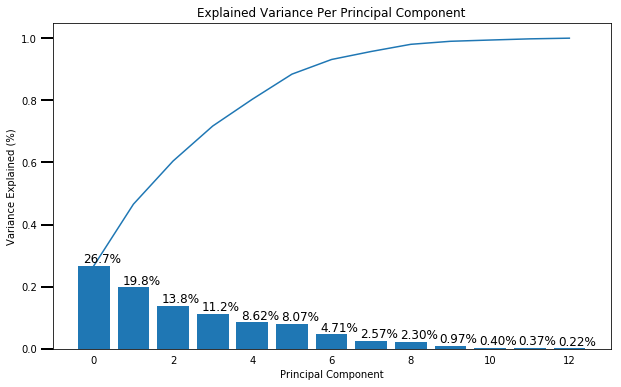

In [58]:
scree_plot(pca13)
pca13.explained_variance_ratio_.sum()

In [76]:
pca7=PCA(7)
X_pca7 = pca7.fit_transform(events_merged_std[X_col])
print(7, pca7.explained_variance_ratio_.sum())

7 0.9311225654632854


In [82]:
dump(pca7,'pca7.model')

['pca7.model']

In [83]:
dump(X_pca7,'X_pca7.numpy')

['X_pca7.numpy']

0.9311225654632882

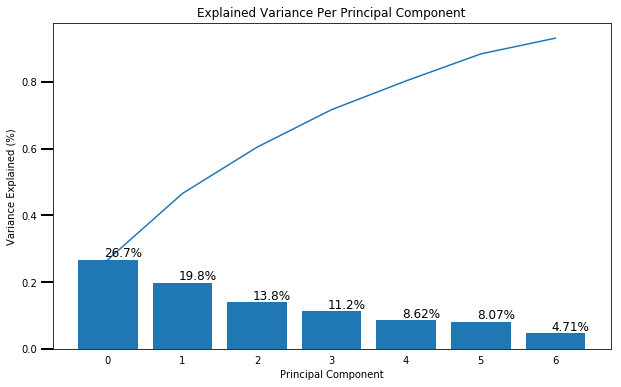

In [60]:
scree_plot(pca7)
pca7.explained_variance_ratio_.sum()

In [61]:
#Modifeid version of function from helper_functions.py in MiniPCA 
def pca_results_rng(full_dataset, pca,dim_rng,pltpca=False):
    '''
    Create a DataFrame of the PCA results
    Includes dimension feature weights and explained variance
    Visualizes the PCA results
    
    input: 
    full_dataset = is the full dataset that was transformed
    pca = is the fit_transformed pca
    dim_rng: list of size to of the first and last dimention to be displayed
    
    '''
    dim_rng[0] = dim_rng[0] - 1  #because first dimention is at index 0
    
    # Dimension indexing
    dimensions = ['Dimension {}'.format(i) for i in range(1, len(pca.components_)+1)]
    dim = dimensions[dim_rng[0]:dim_rng[1]]
    
    # PCA components
    components = pd.DataFrame(np.round(pca.components_, 4), columns = full_dataset.keys())
    components.index = dimensions
    comp = components.iloc[dim_rng[0]:dim_rng[1]]

    # PCA explained variance
    ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
    variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
    variance_ratios.index = dimensions
    vr = variance_ratios.iloc[dim_rng[0]:dim_rng[1]]

    if pltpca == True:
        fig, ax = plt.subplots(figsize = (20,8))

        # Plot the feature weights as a function of the components
        comp.plot(ax = ax, kind = 'bar');
        ax.set_ylabel("Feature Weights")
        ax.set_xticklabels(dim, rotation=0)

        # Display the explained variance ratios
        for i, ev in enumerate(pca.explained_variance_ratio_):
            if int(i) >= dim_rng[0] and int(i) < dim_rng[1]:
                ax.text(i-dim_rng[0], ax.get_ylim()[1], "Explained Variance\n%.4f"%(ev))

    # Return a concatenated DataFrame
    return pd.concat([vr, comp], axis = 1)

In [62]:
res = pca_results_rng(events_merged_std[X_col],pca7,[1,6])

In [63]:
res.drop(columns=['Explained Variance'],inplace=True)

In [64]:
print("Dimension 1")
print(res.loc['Dimension 1',:].sort_values(ascending=False)[:5])
print(res.loc['Dimension 1',:].sort_values(ascending=False)[-5:])
print("Dimension 2")
print(res.loc['Dimension 2',:].sort_values(ascending=False)[:5])
print(res.loc['Dimension 2',:].sort_values(ascending=False)[-5:])
print("Dimension 3")
print(res.loc['Dimension 3',:].sort_values(ascending=False)[:5])
print(res.loc['Dimension 3',:].sort_values(ascending=False)[-5:])
print("Dimension 4")
print(res.loc['Dimension 4',:].sort_values(ascending=False)[:5])
print(res.loc['Dimension 4',:].sort_values(ascending=False)[-5:])
print("Dimension 5")
print(res.loc['Dimension 5',:].sort_values(ascending=False)[:5])
print(res.loc['Dimension 5',:].sort_values(ascending=False)[-5:])
print("Dimension 6")
print(res.loc['Dimension 6',:].sort_values(ascending=False)[:5])
print(res.loc['Dimension 6',:].sort_values(ascending=False)[-5:])

Dimension 1
income                 0.6995
age                    0.6813
gender_F               0.1476
memb_leng              0.0558
offer_informational    0.0019
Name: Dimension 1, dtype: float64
difficulty       -0.0012
duration         -0.0017
web              -0.0018
offer_discount   -0.0025
gender_M         -0.1472
Name: Dimension 1, dtype: float64
Dimension 2
memb_leng      0.9976
gender_M       0.0299
offer_bogo     0.0031
reward_offd    0.0020
difficulty     0.0006
Name: Dimension 2, dtype: float64
social           -0.0019
offer_discount   -0.0026
income           -0.0150
gender_F         -0.0283
age              -0.0537
Name: Dimension 2, dtype: float64
Dimension 3
age               0.7285
gender_M          0.0958
memb_leng         0.0235
offer_discount    0.0042
web               0.0041
Name: Dimension 3, dtype: float64
reward_offd   -0.0058
social        -0.0068
offer_bogo    -0.0079
gender_F      -0.0971
income        -0.6708
Name: Dimension 3, dtype: float64
Dimension 4
off

In [65]:
import time
import pickle

In [66]:
df_Xpca7 = pd.DataFrame(X_pca7)
toy_dataset = df_Xpca7.sample(n=int(df_Xpca7.shape[0]*0.3))

In [67]:
centers_t = []
scores_t = []

for ii in range(1,31):
    
    if ii>1:
        k_pick_t = open('kdict_t.pickle',"rb")
        k_dict_t = pickle.load(k_pick_t)
        scores_t = k_dict_t['scores']
        centers_t = k_dict_t['centers']
    
    #if ii>=centers_t[len(centers_t)-1]:
    time1 = time.time()
    print('Fitting ',ii,' kmean centers ')
    kmeans_t = KMeans(ii)
    model_t = kmeans_t.fit(toy_dataset.values)
    labels_t = model_t.predict(toy_dataset.values)
    centers_t.append(ii)
    scores_t.append(abs(model_t.score(toy_dataset)))
    time2 = (time.time() - time1)/60
    print('Loop ',ii,' took ', time2, ' minutes to complete')

    k_dict_t = {'scores': scores_t,
             'centers': centers_t}

    k_pick_t = open('kdict_t.pickle',"wb")
    pickle.dump(k_dict_t,k_pick_t)

Fitting  1  kmean centers 
Loop  1  took  0.0015137632687886556  minutes to complete
Fitting  2  kmean centers 
Loop  2  took  0.004946756362915039  minutes to complete
Fitting  3  kmean centers 
Loop  3  took  0.007029592990875244  minutes to complete
Fitting  4  kmean centers 
Loop  4  took  0.0072899262110392255  minutes to complete
Fitting  5  kmean centers 
Loop  5  took  0.0114556352297465  minutes to complete
Fitting  6  kmean centers 
Loop  6  took  0.013671871026357014  minutes to complete
Fitting  7  kmean centers 
Loop  7  took  0.05232921838760376  minutes to complete
Fitting  8  kmean centers 
Loop  8  took  0.05015252828598023  minutes to complete
Fitting  9  kmean centers 
Loop  9  took  0.07350043058395386  minutes to complete
Fitting  10  kmean centers 
Loop  10  took  0.05678030252456665  minutes to complete
Fitting  11  kmean centers 
Loop  11  took  0.06189866463343303  minutes to complete
Fitting  12  kmean centers 
Loop  12  took  0.07842197020848592  minutes to c

In [68]:
k_dict_t['centers']

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30]

In [69]:


kmeans_scores = pd.DataFrame({'centers': k_dict_t['centers'],'scores': k_dict_t['scores']})
kmeans_scores = kmeans_scores.drop_duplicates('centers')

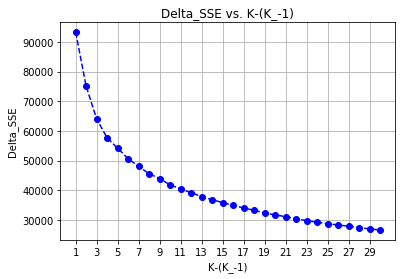

In [70]:
#5% sample
plt.plot(kmeans_scores['centers'],kmeans_scores['scores'], linestyle='--', marker='o', color='b');
plt.xlabel('K-(K_-1)');
plt.ylabel('Delta_SSE');
plt.xticks(np.arange(1,30,step=2));
plt.grid()
plt.title('Delta_SSE vs. K-(K_-1)');

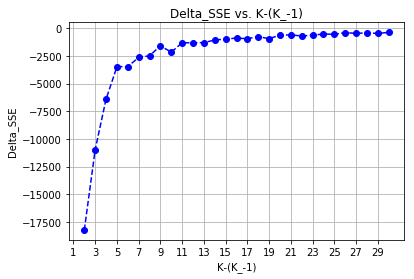

In [71]:
#5% sample
plt.plot(kmeans_scores['centers'],kmeans_scores['scores'].diff(), linestyle='--', marker='o', color='b');
plt.xlabel('K-(K_-1)');
plt.ylabel('Delta_SSE');
plt.xticks(np.arange(1,30,step=2));
plt.grid()
plt.title('Delta_SSE vs. K-(K_-1)');

In [75]:
K5 = KMeans(5)

In [84]:
K5.fit(X_pca7)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [85]:
dump(K5,'K5.model')

['K5.model']

### 4.1 - Segment and Apply Models to Population Segments

In [94]:
pca_model = load('pca7.model')
kmeans_model = load('K5.model')

In [101]:
ems_viewed_false = events_merged_std[events_merged_std['event_offer_viewed']==0]
ems_viewed_true = events_merged_std[events_merged_std['event_offer_viewed']==1]
ems_purch_false = ems_viewed_true[ems_viewed_true['event_offer_completed']==0]
ems_purch_true = ems_viewed_true[ems_viewed_true['event_offer_completed']==1]

In [106]:
Xpca_ems_all = pca_model.transform(events_merged_std[X_col])
Xpca_emsv_false = pca_model.transform(ems_viewed_false[X_col])
Xpca_emsv_true = pca_model.transform(ems_viewed_true[X_col])
Xpca_emsp_false = pca_model.transform(ems_purch_false[X_col])
Xpca_emsp_true = pca_model.transform(ems_purch_true[X_col])

In [110]:
k_ems_all = kmeans_model.predict(Xpca_ems_all)
k_emsv_false = kmeans_model.predict(Xpca_emsv_false)
k_emsv_true = kmeans_model.predict(Xpca_emsv_true)
k_emsp_false = kmeans_model.predict(Xpca_emsp_false)
k_emsp_true = kmeans_model.predict(Xpca_emsp_true)

In [111]:
label_all= np.unique(k_emsv_all,return_counts=True)
label_v_false = np.unique(k_emsv_false,return_counts=True)
label_v_true = np.unique(k_emsv_true,return_counts=True)
label_p_false = np.unique(k_emsp_false,return_counts=True)
label_p_true = np.unique(k_emsp_true,return_counts=True)

(66501,)

In [112]:
def props(label): return label[1]/label[1].sum()

In [113]:
lprops_all = props(label_all)
lprops_v_false = props(label_v_false)
lprops_v_true = props(label_v_true)
lprops_p_false = props(label_p_false)
lprops_p_true = props(label_p_true)

In [283]:
props = pd.DataFrame(lprops_all,columns=['all'])
props['uviewed'] = lprops_v_false
props['viewed'] = lprops_v_true
props['viewed_and_nopurch'] = lprops_p_false
props['viewed_and_purch'] = lprops_p_true

In [288]:
props['id'] = props.index

In [289]:
props

,all,uviewed,viewed,viewed_and_nopurch,viewed_and_purch,id
0,0.248447,0.273554,0.239420,0.290245,0.196634,0
1,0.164539,0.153921,0.168357,0.151586,0.182475,1
2,0.215155,0.211349,0.216523,0.275931,0.166510,2
3,0.163862,0.169159,0.161958,0.069777,0.239560,3
4,0.207997,0.192017,0.213742,0.212461,0.214821,4


In [376]:
props_view = props[['uviewed','viewed','id']].melt(id_vars=['id'],value_vars=['uviewed','viewed'])
props_purch = props[['viewed_and_nopurch','viewed_and_purch','id']].melt(id_vars=['id'],value_vars=['viewed_and_nopurch','viewed_and_purch'])

In [435]:
###  Z-Test 

#H_0: p_0 = p_1
#H_1: p_0 < or > p_1


n_obs_view = np.array([k_emsv_true.shape[0],k_emsv_false.shape[0]])

stat_v = []
p_val_v = []

for obs in zip(label_v_true[1],label_v_false[1]):
    stat,pval = proportions_ztest(np.array([obs[0],obs[1]]),n_obs_view,alternative='two-sided')
    stat_v.append(stat)
    p_val_v.append(pval)

n_obs_purch = np.array([k_emsp_true.shape[0],k_emsp_false.shape[0]])

stat_p = []
p_val_p = []

for obs in zip(label_p_true[1],label_p_false[1]):
    stat,pval = proportions_ztest(np.array([obs[0],obs[1]]),n_obs_purch,alternative='two-sided')
    stat_p.append(stat)
    p_val_p.append(pval)
    

Text(0,0.36,'** : p < 0.01')

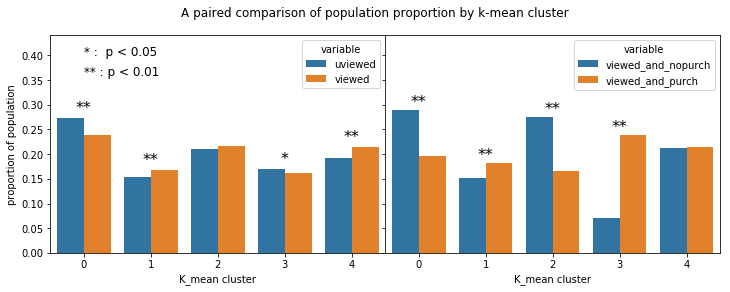

In [436]:
fig_4_1a, ax_4_1 = plt.subplots(nrows=1, ncols=2,sharey=True,figsize=(12,4))
fig_4_1a.suptitle('A paired comparison of population proportion by k-mean cluster')
fig_4_1a.subplots_adjust(wspace = 0)
sns.barplot(data=props_view,x='id',y='value',hue='variable',ax=ax_4_1[0])

t1_yoffsets = []
for x in ax_4_1[0].get_xticks():
    t1_yoffsets.append(props_view[props_view['id']==x]['value'].max())
    if p_val_v[x] < 0.01:
        ax_4_1[0].text(x, t1_yoffsets[x]+0.005 , "**", fontsize=16,ha='center', va='bottom', color=col)
        continue
    elif p_val_v[x] < 0.05:
        ax_4_1[0].text(x, t1_yoffsets[x]+0.005 , "*", fontsize=16,ha='center', va='bottom', color=col)
        continue

ax_4_1[0].set_ybound(0,props_view['value'].max()+0.1)


sns.barplot(data=props_purch,x='id',y='value',hue='variable',ax=ax_4_1[1])

t2_yoffsets = []
for x in ax_4_1[1].get_xticks():
    t2_yoffsets.append(props_purch[props_purch['id']==x]['value'].max())
    if p_val_p[x] < 0.01:
        ax_4_1[1].text(x, t2_yoffsets[x] , "**", fontsize=16,ha='center', va='bottom', color=col)
        continue
    elif p_val_p[x] < 0.05:
        ax_4_1[1].text(x, t2_yoffsets[x] , "*", fontsize=16,ha='center', va='bottom', color=col)
        continue

ax_4_1[1].set_xlabel('K_mean cluster')
ax_4_1[0].set_xlabel('K_mean cluster')
ax_4_1[0].set_ylabel('proportion of population')
ax_4_1[1].set_ylabel('')
ax_4_1[1].set_ybound(0,props_purch['value'].max()+0.15)
ax_4_1[0].annotate(s='* :  p < 0.05',xy=(0,0.4), fontsize=12)
ax_4_1[0].annotate(s='** : p < 0.01',xy=(0,0.36), fontsize=12)


#### Viewed v Unviewed
High Significant difference (p < 0.01) in clusters 0,1, and 4
Significant difference (P < 0.05) in cluster 3

#### Viewed and Purchased v Not-Purchased
High Significant difference (p < 0.01) in clusters 0,1,2,3

### 4.3 - Analize clusters for comprehension of differences


In [455]:
df_Xpca_emsv_true = pd.DataFrame(Xpca_emsv_true)
df_Xpca_emsv_false = pd.DataFrame(Xpca_emsv_false)
df_Xpca_emsp_true = pd.DataFrame(Xpca_emsp_true)
df_Xpca_emsp_false = pd.DataFrame(Xpca_emsp_false)
df_Xpca_emsv_true['cluster'] = k_emsv_true
df_Xpca_emsv_false['cluster'] = k_emsv_false
df_Xpca_emsp_true['cluster'] = k_emsp_true
df_Xpca_emsp_false['cluster'] = k_emsp_false


In [458]:
df_Xpca_emsv_true['purchase'] = True
df_Xpca_emsv_false['purchase'] = False
df_Xpca_emsp_true['purchase'] = True
df_Xpca_emsp_false['purchase'] = False


In [459]:
df_Xpca_emsv = df_Xpca_emsv_true.append(df_Xpca_emsv_false)
df_Xpca_emsp = df_Xpca_emsp_true.append(df_Xpca_emsp_false)

In [465]:
df_Xpca_emsv_melt = df_Xpca_emsv.melt(id_vars=['cluster','purchase'],value_vars=[0, 1, 2, 3, 4, 5, 6],var_name='pca_dim')
df_Xpca_emsp_melt = df_Xpca_emsp.melt(id_vars=['cluster','purchase'],value_vars=[0, 1, 2, 3, 4, 5, 6],var_name='pca_dim')

In [472]:
v_clust_sig = [0,1,3,4]
p_clust_sig = [0,1,2,3]

In [538]:
p_table_view = pd.DataFrame(columns=['k_mean','pca_dim','p_value'])

for k_m in df_Xpca_emsv_melt.cluster.unique():
    for p_d in df_Xpca_emsv_melt.pca_dim.unique():
        stat,p_val = stats.ttest_ind(df_Xpca_emsv_melt[(df_Xpca_emsv_melt.cluster == k_m) & (df_Xpca_emsv_melt.purchase == False) & (df_Xpca_emsv_melt.pca_dim == p_d)].value,
                    df_Xpca_emsv_melt[(df_Xpca_emsv_melt.cluster == k_m) & (df_Xpca_emsv_melt.purchase == True) &  (df_Xpca_emsv_melt.pca_dim == p_d)].value,
                    equal_var=False)
        p_table_view = p_table_view.append({'k_mean': k_m, 'pca_dim': p_d, 'p_value': p_val},ignore_index=True)
            

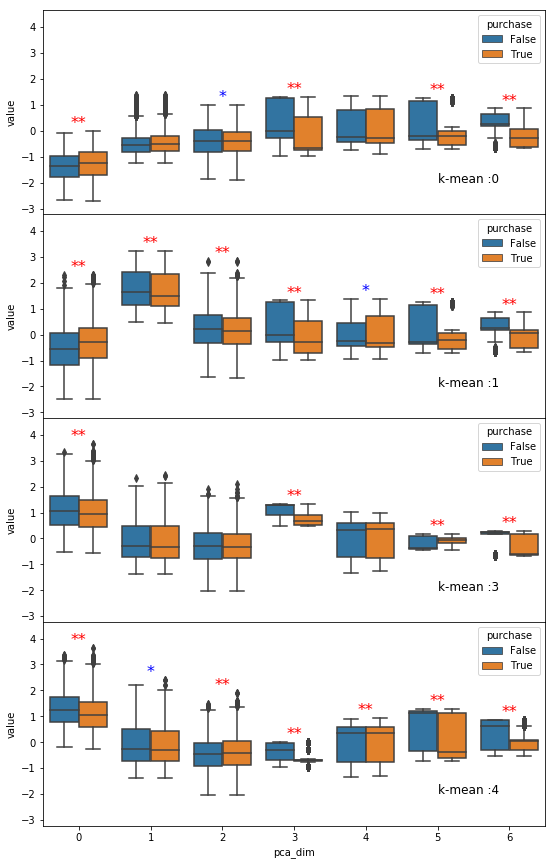

In [603]:
fig_4_3a, ax_4_3a = plt.subplots(nrows = 4, ncols= 1, sharey=True, figsize=(9,15))
for cl in range(len(v_clust_sig)):
    sns.boxplot(data=df_Xpca_emsv_melt[df_Xpca_emsv_melt.cluster==v_clust_sig[cl]],x='pca_dim',y='value',hue='purchase',ax=ax_4_3a[cl])
fig_4_3a.subplots_adjust(hspace = 0)

col1 = 'red'
col2 = 'blue'

for ax in range(len(ax_4_3a)): # loop for every subplot
    yoffsets = []  # list to store yoffsets for annotations
    for x in ax_4_3a[ax].get_xticks(): # loop through every boxplot in subplot
        yoffsets.append(df_Xpca_emsv_melt[(df_Xpca_emsv_melt.cluster==v_clust_sig[ax]) &
                                         (df_Xpca_emsv_melt.pca_dim==x)].value.max()) # position above max value
        if float(p_table_view[(p_table_view.k_mean == v_clust_sig[ax]) & (p_table_view.pca_dim == x)].p_value) < 0.01:
            ax_4_3a[ax].text(x, yoffsets[x] , "**", fontsize=16,ha='center', va='bottom', color=col1)
            continue
        elif float(p_table_view[(p_table_view.k_mean == v_clust_sig[ax]) & (p_table_view.pca_dim == x)].p_value) < 0.05:
            ax_4_3a[ax].text(x, yoffsets[x] , "*", fontsize=16,ha='center', va='bottom', color=col2)
            continue

ax_4_3a[0].set_ybound(df_Xpca_emsv_melt.value.min()-0.5,df_Xpca_emsv_melt.value.max()+1)
for blah in range(len(ax_4_3a)):
    ax_4_3a[blah].annotate(s='k-mean :'+ str(v_clust_sig[blah]),xy=(5,-2),fontsize=12)


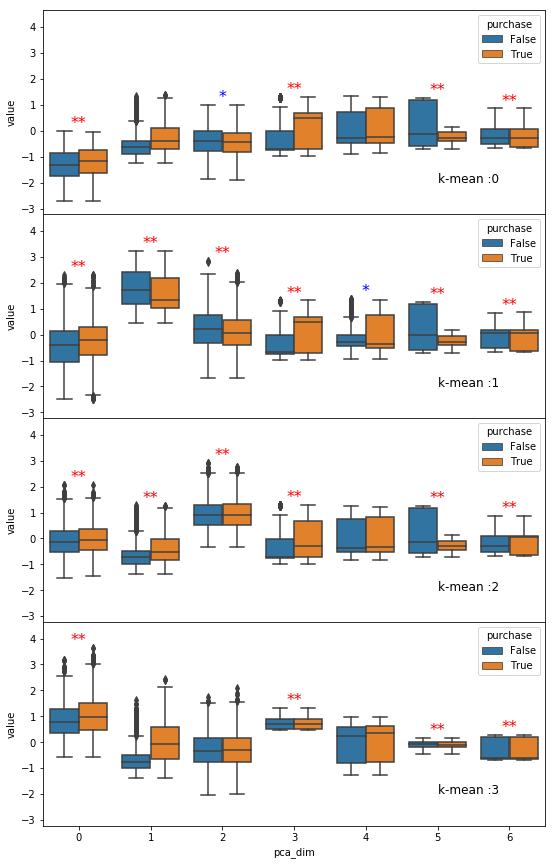

In [604]:
fig_4_3b, ax_4_3b = plt.subplots(nrows = 4, ncols= 1,sharey=True, figsize=(9,15))
for cl in range(len(p_clust_sig)):
    sns.boxplot(data=df_Xpca_emsp_melt[df_Xpca_emsp_melt['cluster']==cl],x='pca_dim',y='value',hue='purchase',ax=ax_4_3b[cl])
fig_4_3b.subplots_adjust(hspace = 0)

col1 = 'red'
col2 = 'blue'

for ax in range(len(ax_4_3b)): # loop for every subplot
    yoffsets = []  # list to store yoffsets for annotations
    for x in ax_4_3b[ax].get_xticks(): # loop through every boxplot in subplot
        yoffsets.append(df_Xpca_emsp_melt[(df_Xpca_emsp_melt.cluster==p_clust_sig[ax]) &
                                         (df_Xpca_emsp_melt.pca_dim==x)].value.max()) # position above max value
        if float(p_table_view[(p_table_view.k_mean == p_clust_sig[ax]) & (p_table_view.pca_dim == x)].p_value) < 0.01:
            ax_4_3b[ax].text(x, yoffsets[x] , "**", fontsize=16,ha='center', va='bottom', color=col1)
            continue
        elif float(p_table_view[(p_table_view.k_mean == p_clust_sig[ax]) & (p_table_view.pca_dim == x)].p_value) < 0.05:
            ax_4_3b[ax].text(x, yoffsets[x] , "*", fontsize=16,ha='center', va='bottom', color=col2)
            continue

ax_4_3b[0].set_ybound(df_Xpca_emsp_melt.value.min()-0.5,df_Xpca_emsp_melt.value.max()+1)
for blah in range(len(ax_4_3b)):
    ax_4_3b[blah].annotate(s='k-mean :'+ str(p_clust_sig[blah]),xy=(5,-2),fontsize=12)

#### Huh...

Well it looks like almost everything is significant....
So I think the most best think to do here is to find where the biggest practical diffierences in median magniture

For viewing, i see practical differences in 